In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
import os
from tqdm.auto import tqdm
from typing import List, Any, Union, Tuple, Dict
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from pandas.core.index import MultiIndex

In [2]:
def is_last(df:pd.DataFrame, row:int)->bool:
    """Return boolean representing if given row is the last row.
    
    Parameters
    ----------
    df:pd.DataFrame,
        The dataframe to check against.
    row:int,
        The index of the row to consider.
    
    Returns
    -------
    A boolean representing if given row is the last one.
    """
    return row+1 == df.shape[0]

In [3]:
def sanitize_name(name:str)->str:
    """Return sanitized name.
        
    Parameters
    ----------
    name: str,
        The name to be sanitize.
        
    Returns
    -------
    The sanitized name.    
    """
    return str(name).replace("_", " ").capitalize()

In [4]:
def histogram_width(df:pd.DataFrame, bar_width:float)->float:
    """Return histogram width for given dataframe and bar width.
    
    Parameters
    ----------
    df:pd.DataFrame,
        Dataframe from which to obtain the curresponding histogram width.
    bar_width:float,
        Width of bars in considered histogram.
        
    Returns
    -------
    Return float representing histogram total width.
    """
    old_index = None
    width = bar_width*df.shape[0]
    for row, index in enumerate(df.index):
        if not is_last(df, row):
            width += sum(get_jumps(df, row, index, old_index))*bar_width
        old_index = index
    return width

In [5]:
def get_jumps(df:pd.DataFrame, row:int, index:Union[List, Any], old_index:Union[List, Any])->List[bool]:
    """Return list representing the detected jumps from given index and old_index.
    
    Parameters
    ----------
    df:pd.DataFrame,
        Dataframe from which to detect index jumps.
    row:int,
        Current row number.
    index:Union[List, Any],
        List of indices of index curresponding to given row number.
    old_index:Union[List, Any],
        Old index.
        
    Returns
    -------
    Returns list of boolean representing if for given index level a jump has been detected.
    """
    if not isinstance(index, (tuple, list)) or old_index is None:
        return tuple()
    return [
        new != old or is_last(df, row)
        for new, old in zip(index[:-1], old_index)
    ]

In [6]:
def remove_duplicated_legend_labels(figure:Figure, axes:Axes, legend_position:str):
    """Remove duplicated labels from the plot legend.
    
    Parameters
    ----------
    figure:Figure,
        Figure containing the labels.
    axes:Axes,
        Axes where to show the labels.
    legend_position:str,
        Legend position, by default "best". Use None for hiding legend.
    """
    handles, labels = figure.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if legend_position is not None:
        axes.legend(by_label.values(), by_label.keys(), loc=legend_position)

In [7]:
def plot_bar(axes: Axes, x:float, y:float, std:float, min_std:float, bar_width:float, color:str, label:str):
    """Plot bar with given properties.
    
    Parameters
    ----------
    axes: Axes,
        Axes object where to plot the bar.
    x:float,
        Position for the left size of the bar.
    y:float,
        Height of the considered bar.
    std:float,
        Standard deviation to plot on top.
    min_std:float,
        Minimum standard deviation to be shown.
    bar_width:float,
        Width of the bar.
    color:str,
        Color of the bar.
    label:str,
        Label of the bar.
    """
    axes.bar(
        x + bar_width/2,
        y+1,
        bottom=-1,
        **({"yerr": std} if std > min_std else {}),
        color=color,
        error_kw={
            "ecolor":"black",
            "alpha":0.75
        },
        width=bar_width,
        capsize=5,
        alpha=0.75,
        label=sanitize_name(label)
    )

In [8]:
def plot_text(axes:Axes, x:float, y:float, text:str, width:float):
    """Plot text with given properties.
    
    Parameters
    ----------
    axes:Axes,
        Axes object where to plot the text.
    x:float,
        Center coordinate for the text horizzontal axes.
    y:float,
        Center coordinate for the text vertical axes.
    text:str,
        Text to be shown.
    width:float,
        Total width of the histogram for normalizing the X position
    """
    axes.text(
        x/(width),
        y/15,
        sanitize_name(text),
        horizontalalignment='center',
        verticalalignment='center',
        transform=axes.transAxes
    )

In [9]:
def get_axes(df:pd.DataFrame, bar_width:float, height:float, dpi:int, title:str)->Tuple[Figure, Axes]:
    """Setup axes for histogram plotting.
    
    Parameters
    ----------
    df:pd.DataFrame,
        Dataframe from which to obtain the curresponding histogram width.
    bar_width:float,
        Width of bars in considered histogram.
    height: float,
        Height of considered histogram.
    dpi:int,
        DPI for rendered images.
    title:str,
        Title of the considered histogram.
        
    Returns
    -----------
    """
    width = histogram_width(df, bar_width)
    fig, axes = plt.subplots(figsize=(width, height), dpi=dpi)
    axes.set_xlim(0, width)
    axes.set_ylim(0)
    axes.set_xticks([])
    axes.yaxis.grid(True, which="both")
    if title is not None:
        axes.set_title(title)
    return fig, axes, width

In [10]:
def get_levels(df:pd.DataFrame)->List[List[Any]]:
    """Return normalized list of dataframe index levels.
    
    Parameters
    ----------
    df:pd.DataFrame,
        Dataframe from which to extract index levels.
    
    Returns
    -------
    List of lists of unique indices.
    """
    if isinstance(df.index, MultiIndex):
        return [
            list(e) for e in df.index.levels
        ]
    else:
        return [df.index.uniques().aslist()]

In [11]:
def validate_positive_floats(**floats:Dict):
    """Validate given parameters."""
    for var_name, value in floats.items():
        if not isinstance(value, (float, int)) or value <=0:
            raise ValueError("Given parameters {var_name} is not a strictly positive float.".format(
                var_name=var_name
            ))

In [15]:
def histogram(
    df:pd.DataFrame,
    bar_width:float=0.3,
    height:float=5,
    dpi:int=100,
    min_std:float=0.01,
    legend_position:str="best",
    title:str=None,
    path:str=None,
    colors:List[str]=None
)->Tuple[Figure, Axes]:
    """Plot histogram corresponding to given dataframe, containing y value and optionally std.
    
    Parameters
    ----------
    df:pd.DataFrame,
        Dataframe from which to extrat data for plotting histogram.
    bar_width:float=0.3,
        Width of the bar of the histogram.
    height:float=5,
        Height of the histogram.
    dpi:int=100,
        DPI for plotting the histograms.
    min_std:float=0.01,
        Minimum standard deviation for showing error bars.
    legend_position:str="best",
        Legend position, by default "best". Use None for hiding legend.
    title:str=None,
        Histogram's title. None for not showing any title (default).
    path:str=None,
        Path where to save the histogram. None for not saving it (default).
    colors:List[str]=None,
        List of colors to be used for innermost index of dataframe.
        By default None, using the default color tableau from matplotlib.
        
    Raises
    ------
    ValueError:
        If given bar_width is not a strictly positive float.
    ValueError:
        If given height is not a strictly positive float.
    
    Returns
    -------
    Tuple containing Figure and Axes of created histogram.
    """
    validate_positive_floats(bar_width=bar_width, height=height)
    
    levels = get_levels(df)
    if colors is None:
        colors = list(TABLEAU_COLORS.keys())
    fig, axes, width = get_axes(df, bar_width, height, dpi, title)

    labels_offsets = {}
    old_index = None
    x = 0
    for i, (index, values) in enumerate(df.iterrows()):
        jumps = get_jumps(df, i, index, old_index)
        old_x = x
        for j, value in enumerate(jumps):
            if value:
                text_x = old_x
                if j in labels_offsets:
                    text_x += labels_offsets[j]
                if is_last(df, i):
                    text_x += bar_width
                else:
                    x += bar_width
                plot_text(axes, text_x/2, j - len(jumps), old_index[j], width)
        old_index = index
        for j, value in enumerate(jumps):
            if value:
                labels_offsets[j] = x
        color = colors[list(levels[-1]).index(index[-1])]
        label = index[-1]
        if len(values)==2:
            y, std = values
        elif len(values)==1:
            y, std = values, 0
        plot_bar(axes, x, y, std, min_std, bar_width, color, label)
        x += bar_width
        
    remove_duplicated_legend_labels(fig, axes, legend_position)
    
    if path is not None:
        fig.savefig(path)

In [16]:
df = pd.read_csv("tests/test_case.csv", index_col=0)
df = df[df.syntetic_negatives==0]
df = df.drop(columns="syntetic_negatives")
index = ["dataset", "resource", "model"]
df = df.drop(columns=df.columns.difference(index+["test_auroc"]))
df = df.groupby(index).agg(["mean", "std"])

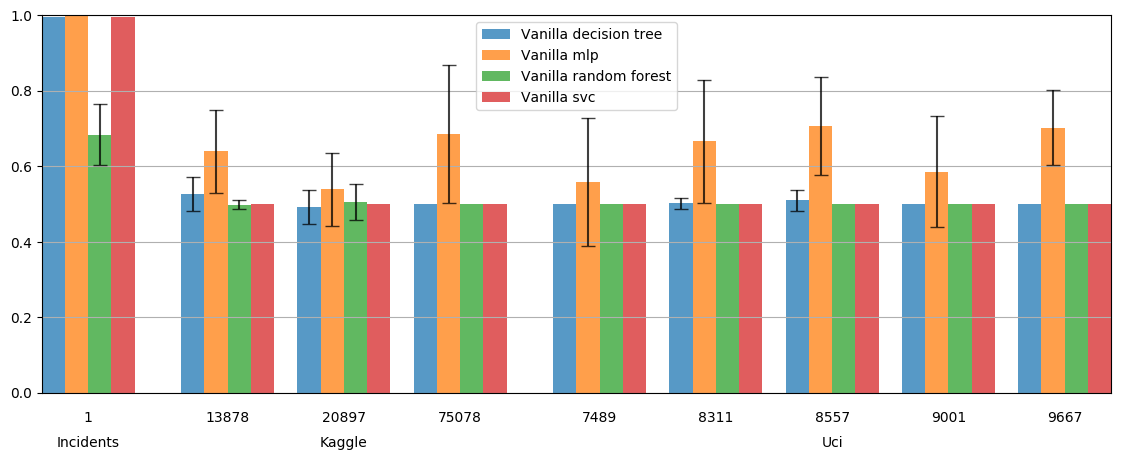

In [17]:
histogram(df["test_auroc"])